## Image Color Mapping and Finding the Eye
This is a notebook that shows off what is actually done in C++ using GPU.

### Auxilary function to display images

In [108]:
%matplotlib inline

from matplotlib import pyplot as plt
from os import path
import numpy as np
import cv2

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()
    

### Image Preprocessing

1. Downsample with Gaussian Pyramid
2. Find the eye.
  1. Canny edge finder
  2. Find contours
  3. Find the joining convex hull
  4. Create a mask for this hull. The mask is resized to the final image size
3. Apply Histogram Specification to normalize color maps
  1. Compute CDF of the reference image
  2. Compute CDF of the input image
  3. Create a mapping from refrence to image CDF
  4. Realize mapping
4. Apply CLAHE on the V channel of the image, converted to HSV.
5. Resize to 256x256
6. Apply the mask (above) to clean up the background

The images supplied vary drastically in their palettes. To simplify feature extraction we need to first normalize them to the same color. 

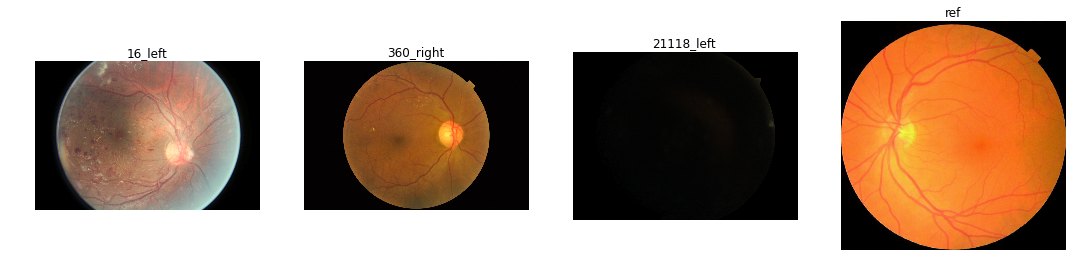

In [109]:
img_path = "/kaggle/retina/train/sample"
# this is the image into the colors of which we want to map
ref_image = cv2.imread(path.join(img_path, "6535_left.jpeg"))
# images picked to illustrate different problems arising during algorithm application
image_names = ["16_left.jpeg", "360_right.jpeg", "21118_left.jpeg"]
image_paths = map(lambda t: path.join(img_path, t), image_names)
images = map(lambda p: cv2.imread(p), image_paths)

# let's see what we've got
image_titles = map(lambda i: path.splitext(i)[0], image_names)
image_titles.append("ref")
images.append(ref_image)
show_images(images, image_titles)

In [110]:
#Pyramid Down & blurr
# Easy-peesy
def pyr_blurr(image):
    return cv2.GaussianBlur(cv2.pyrDown(ref_image), (7, 7), 30.)

ref_image = pyr_blurr(ref_image)
images = map(lambda i: pyr_blurr(i), images)


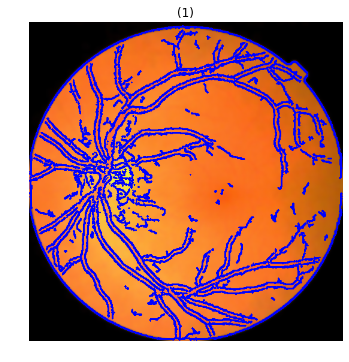

14345 points


In [91]:
def display_contours(image, contours, color = (255, 0, 0), thickness = -1, title = None):
    imShow = image.copy()
    for i in range(0, len(contours)):
        cv2.drawContours(imShow, contours, i, color, thickness)
    show_images([imShow], scale=0.7, titles=title)
    
image = ref_image

# this is a good threshold for Canny edge finder, but it does not always work. We will see how to deal with it furhter on.
thresh = 4
# Searcing for the eye
# Let's see how this works setp-by-step
# convert to a one channel image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny edge finder
edges = np.array([])
edges = cv2.Canny(gray, thresh, thresh * 3, edges)

# Find contours
# second output is hierarchy - we are not interested in it.
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Let's see what we've got:
display_contours(image, contours, thickness=2)
print "{:d} points".format(len(np.vstack(np.array(contours))))

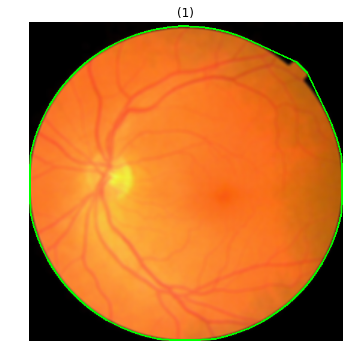

In [95]:
# Now let's get only what we need out of it
hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
hull = np.vstack(hull_contours)

# we only get one contour out of it, let's see it
display_contours(image, [hull], thickness=2, color=(0, 255, 0))

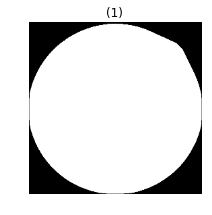

In [100]:
# Now let's create a mask for this image and later resize it to 256x256. It will be handy in the future
def createMask((rows, cols), hull):
    # black image
    mask = np.zeros((rows, cols), dtype=np.uint8)
    # blit our contours onto it in white color
    cv2.drawContours(mask, [hull], 0, 255, -1)
    return mask

mask = createMask(image.shape[0:2], hull)
mask = cv2.resize(mask, (256, 256))

show_images([mask])

###Putting it all together:

In [118]:
def find_eye(image, thresh = 4, size=256):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Canny edge finder
    edges = np.array([])
    edges = cv2.Canny(gray, thresh, thresh * 3, edges)

    # Find contours
    # second output is hierarchy - we are not interested in it.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Now let's get only what we need out of it
    hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
    hull = np.vstack(hull_contours)
    
    def createMask((rows, cols), hull):
        # black image
        mask = np.zeros((rows, cols), dtype=np.uint8)
        # blit our contours onto it in white color
        cv2.drawContours(mask, [hull], 0, 255, -1)
        return mask

    mask = createMask(image.shape[0:2], hull)
    
    # returning the hull to illustrate a few issues below
    return cv2.resize(mask, (size, size)), hull